# Predicting cloud cover using neural networks

In [1]:
import numpy as np
import scipy.sparse as sp
np.random.seed(12)

import warnings
#Comment this to turn on warnings
warnings.filterwarnings('ignore')

from model_comparison_2 import model_comparison
from resample import resample
import algorithms
import matplotlib.pyplot as plt
import seaborn as sns
import netCDF4 as n
from sklearn.linear_model import LinearRegression
#from mpl_toolkits.axes_grid1 import make_axes_locatable

from utils import train_test_split
%matplotlib inline
#%matplotlib notebook

from deepNN import NeuralNetRegressor

from sklearn.neural_network import MLPRegressor
from utils import mean_squared_error, A_R2, NRMSE, transforming_predictorspace, standardicing_responce

from sklearn.preprocessing import StandardScaler

import itertools


In [2]:
# reading test
path = "./files/"
filenames = ["specific_humidity_Europa_sp.nc", "relative_humidity_Europa_sp.nc", "pressure_Europa_sp.nc",  
             "temperature_Europa_sp.nc", "total_cloud_cover_Europa_sp.nc"]


cloud = n.Dataset(path + filenames[-1], "r")
relative = n.Dataset(path + filenames[1], "r")
specific = n.Dataset(path + filenames[0], "r")
pressure = n.Dataset(path + filenames[2], "r")
temperature = n.Dataset(path + filenames[3], "r")

In [3]:
#print(cloud.variables)
tcc = cloud.variables["tcc"][:][:][:].data

# Retriving ground values, these are available at six different pressure levels. 
rel = relative.variables["r"][:][:][:][:].data
#level = relative.variables["level"][:][0].data
spe = specific.variables["q"][:][:][:][:].data

surf_pre = pressure.variables["sp"][:][:][:].data
temp = temperature.variables["t2m"][:][:][:].data

In [4]:
def logit_inv(x): # sigmoid?
    return np.exp(x)/(1+np.exp(x))

def logit(x):
    return np.log((x + 1e-12)/(1+1e-12 - x))

In [5]:
# for one certain timestep 

n_days = 7

TCC = []
REL = []
SPE = []
PRE = []
TEMP = []


for t in range(int(n_days*4)):
    TCC.append(tcc[t][:][:].flatten())
    REL.append(rel[t][0][:][:].flatten())
    SPE.append(spe[t][0][:][:].flatten())
    PRE.append(surf_pre[t][:][:].flatten())
    TEMP.append(temp[t][:][:].flatten())


In [6]:
y =(np.array(TCC).flatten())
temp = y[y<1]
y[y>1] = temp.max()
print(y.min()>0)

X = np.array([np.array(REL).flatten(), np.array(SPE).flatten(), np.array(PRE).flatten(), np.array(TEMP).flatten()])
#y = logit(np.array(TCC).flatten())

True


In [7]:
#plt.figure(figsize = (20,20))
#plt.plot(y)

In [8]:
np.array(TCC).min(), np.array(TCC).max()

(9.99866855977416e-13, 1.0000000000009999)

In [9]:
y.min(), y.max()

(9.99866855977416e-13, 0.9999694810258271)

In [10]:
np.shape(X[0]),np.shape(X[1]),np.shape(X[2]),np.shape(X[3]), np.shape(y)

((131516,), (131516,), (131516,), (131516,), (131516,))

In [11]:
y = y.reshape((len(y),1))
X = X.T

In [12]:
np.shape(X), np.shape(y)

((131516, 4), (131516, 1))

In [13]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, split_size = 0.2)
import sklearn.model_selection as s
X_train, X_test, y_train, y_test = s.train_test_split(X, y, test_size = 0.2)


scaler = StandardScaler()
# Kunne brukt fit transform
fit = scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
np.shape(X_train), np.shape(X_test), np.shape(y_train),  np.shape(y_test)

((105212, 4), (26304, 4), (105212, 1), (26304, 1))

In [15]:
y_train.max(), y_train.min()

(0.9999694810258271, 9.99866855977416e-13)

# ONE HIDDEN LAYER - sigmoid - 1000 epochs

In [16]:
nr_epochs = 1000

n_nodes = [10,30,50,100,200,300,400,500]

# Array which contains all the "calibrated models ".
results = []

for n in n_nodes:
    model = NeuralNetRegressor(n_hidden = [n],  
                               epochs=nr_epochs, 
                               eta=0.0001, # larger eta results in exploding gradients, becomes NaN.
                               shuffle = True, 
                               batch_size = 10,
                               seed = None, 
                               alpha = 0.0001, # dette er for relu ikke det samme som penaltien i scikit learn  
                               activation = 'sigmoid')

    p = model.fit(X_train, y_train, X_test, y_test)
    model.predict(X_test)
    results.append(p)
    print("Finished model: " + str(n) + " mse " + str(np.nanmean(p.eval_['valid_preform'])) + " r2 " + str(np.nanmean(p.eval_['valid_preform_r2'])))


Finished model: 10 mse 0.7899215483867515 r2 0.21007845161324876
Finished model: 30 mse 0.7641065366829045 r2 0.2358934633170956
Finished model: 50 mse 0.7676196003655426 r2 0.23238039963445772
Finished model: 100 mse 0.7667036345859819 r2 0.23329636541401824
Finished model: 200 mse 0.7656675446012151 r2 0.23433245539878506
Finished model: 300 mse 0.7697397250407979 r2 0.2302602749592023
Finished model: 400 mse 0.764364791165631 r2 0.23563520883436925
Finished model: 500 mse 0.7659472612116835 r2 0.23405273878831667


/uio/hume/student-u89/hannasv/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/uio/hume/student-u89/hannasv/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/uio/hume/student-u89/ha

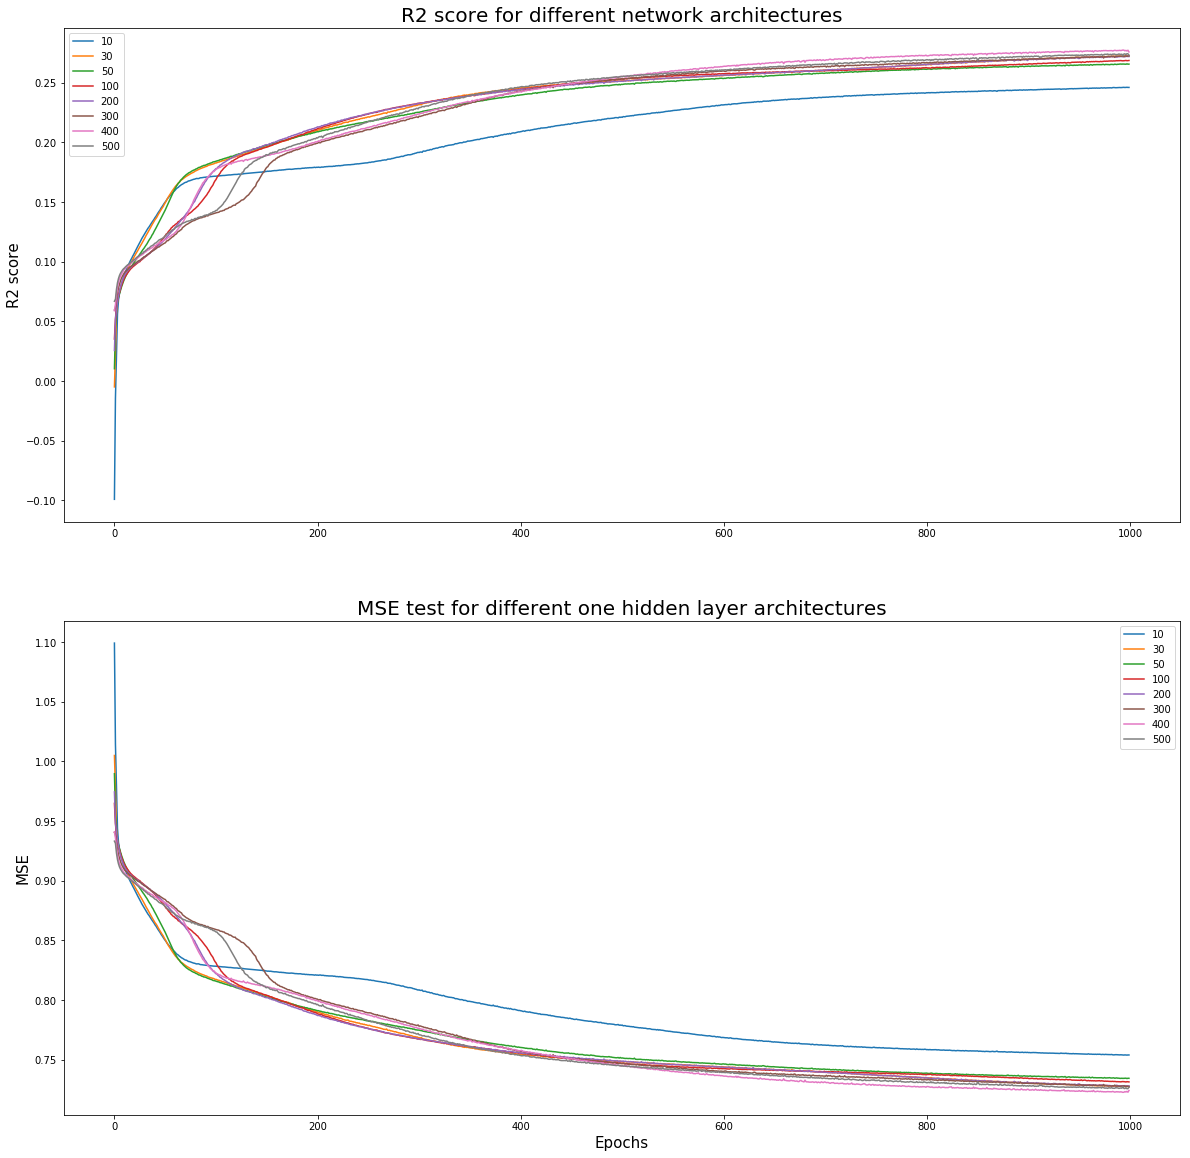

In [17]:
plt.figure(figsize = (20,20))

counter = 0
for model in results:
    mse_train = model.eval_['train_preform']
    mse_test = model.eval_['valid_preform']
    cost_train = model.eval_["cost_train"]
    r2_test = model.eval_['valid_preform_r2']

    ax1 = plt.subplot(211)
    plt.plot(r2_test, label = str(n_nodes[counter])) 
    plt.title("R2 score for different network architectures", fontsize = 20)
    plt.ylabel("R2 score", fontsize = 15)
    plt.legend()
    
    # Alle disse blir like.
    ax2 = plt.subplot(212)
    plt.plot(mse_test, label = str(n_nodes[counter])) 
    plt.title("MSE test for different one hidden layer architectures", fontsize = 20)
    plt.ylabel("MSE", fontsize = 15)
    plt.legend()
    
    counter += 1

plt.xlabel("Epochs", fontsize = 15)
plt.savefig("results/figures/NN_one_hidden_layer_sigmoid_1000epochs_eta0.0001_featured_scaled_7.png")

In [18]:
print(len(results))

8


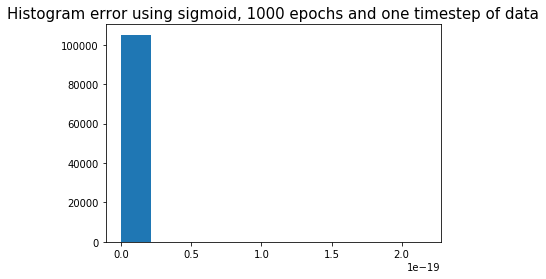

In [19]:
# Look the same for all models.
error = results[0].model_error
plt.hist(error)
plt.title("Histogram error using sigmoid, 1000 epochs and one timestep of data", fontsize = 15)
plt.savefig("results/figures/NN_one_hidden_layer_sigmoid_1000epochs_eta0.0001_featured_scaled_1_error.png")
# They all look the same. 

# ONE HIDDEN LAYER - ELU - 1000 epochs

In [20]:
nr_epochs = 1000

n_nodes = [10, 30, 50, 100, 200, 300, 400, 500]

# Array which contains all the "calibrated models ".
results = []

for n in n_nodes:
    model = NeuralNetRegressor(n_hidden = [n],  
                               epochs=nr_epochs, 
                               eta=0.0001, # larger eta results in exploding gradients, becomes NaN.
                               shuffle = True, 
                               batch_size = 10,
                               seed = None, 
                               alpha = 0.0001, # dette er for relu ikke det samme som penaltien i scikit learn  
                               activation = 'elu')

    p = model.fit(X_train, y_train, X_test, y_test)
    model.predict(X_test)
    results.append(p)
    print("Finished model: " + str(n))


Finished model: 10
Finished model: 30
Finished model: 50
Finished model: 100
Finished model: 200
Finished model: 300
Finished model: 400
Finished model: 500


/uio/hume/student-u89/hannasv/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/uio/hume/student-u89/hannasv/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/uio/hume/student-u89/ha

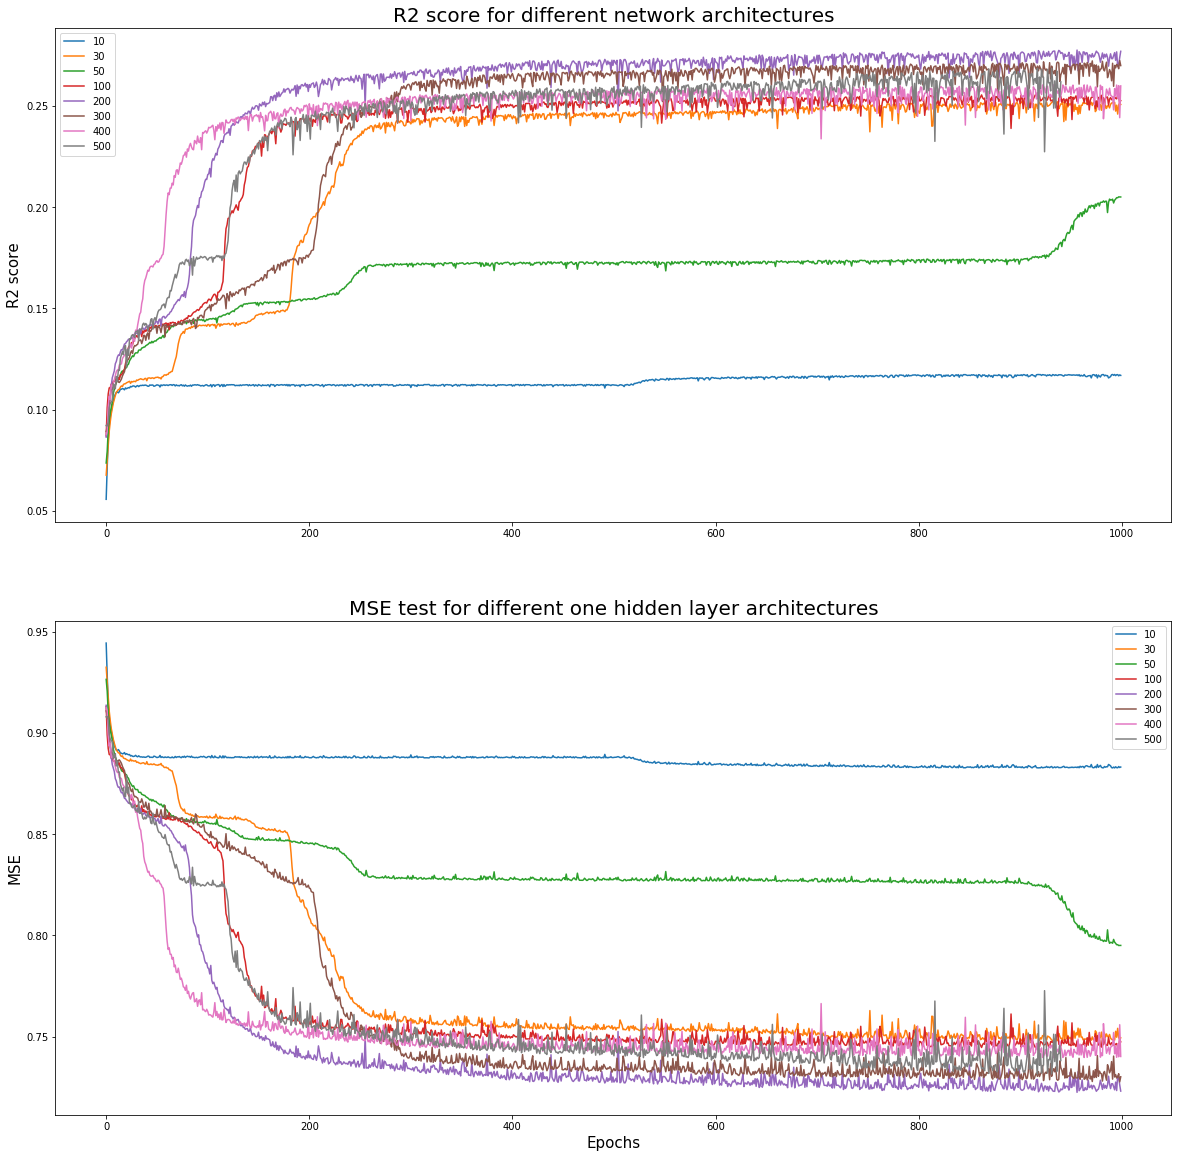

In [21]:
# Plot results as a function of  epochs to see if a certain nr of nodes makes a difference. 

plt.figure(figsize = (20,20))

counter = 0
for model in results:
    mse_train = model.eval_['train_preform']
    mse_test = model.eval_['valid_preform']
    cost_train = model.eval_["cost_train"]
    r2_test = model.eval_['valid_preform_r2']

    ax1 = plt.subplot(211)
    plt.plot(r2_test, label = str(n_nodes[counter])) 
    plt.title("R2 score for different network architectures", fontsize = 20)
    plt.ylabel("R2 score", fontsize = 15)
    plt.legend()
    
    # Alle disse blir like.
    ax2 = plt.subplot(212)
    plt.plot(mse_test, label = str(n_nodes[counter])) 
    plt.title("MSE test for different one hidden layer architectures", fontsize = 20)
    plt.ylabel("MSE", fontsize = 15)
    plt.legend()
    
    counter += 1

plt.xlabel("Epochs", fontsize = 15)
plt.savefig("results/figures/NN_one_hidden_layer_elu_1000epochs_eta0.0001_featured_scaled_7.png")

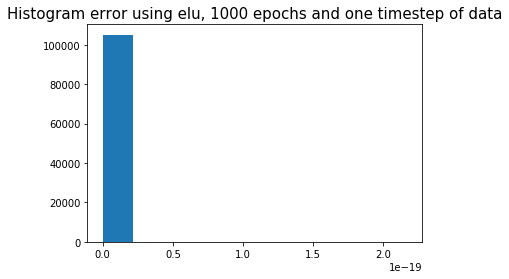

In [22]:
error = results[7].model_error
plt.hist(error)
plt.title("Histogram error using elu, 1000 epochs and one timestep of data", fontsize = 15)
plt.savefig("results/figures/NN_one_hidden_layer_elu_1000epochs_eta0.0001_featured_scaled_1_error.png")
# They all look the same. 

# Running two hidden layers - combinations in [100, 125, 150, 175, 200]
## Ran fro all permutations (includes ordering) didn't give a large manifestations ~0.01

In [16]:
n_1 = [100, 125]
n_2 = [100, 150]
n_7 = [100, 175]
n_3 = [100, 200]

n_4 = [125, 150]
n_8 = [125, 175]
n_5 = [125, 200]

n_9 = [150, 175]
n_6 = [150, 200]

n_10 = [175,200]

results = []

#permutations_of_nodes = list(itertools.permutations(n_1)) + list(itertools.permutations(n_2)) \
#+ list(itertools.permutations(n_3))+ list(itertools.permutations(n_4)) + list(itertools.permutations(n_5))+ \
#list(itertools.permutations(n_6)) + list(itertools.permutations(n_7)) + list(itertools.permutations(n_8)) +list(itertools.permutations(n_9)) + list(itertools.permutations(n_10))

combinations_of_nodes = comb = [n_1, n_2, n_3, n_4, n_5, n_6, n_7, n_8, n_9, n_10]

for per in combinations_of_nodes:
    model = NeuralNetRegressor(n_hidden = per,  
                               epochs=100, 
                               eta=0.0001,
                               shuffle=True, 
                               batch_size=10,
                               seed=None, 
                               alpha=0.0001, # Dette er for relu ikke det samme som penaltien i scikit learn  
                               activation='sigmoid')

    p = model.fit(X_train, y_train, X_test, y_test)
    model.predict(X_test)
    results.append(p)
    print("finished model: " + str(per) + " performance " + str(np.nanmean(model.eval_["valid_preform"])) )


finished model: [100, 125] performance 0.8835555902770763
finished model: [100, 150] performance 0.8890828511394331
finished model: [100, 200] performance 0.8847142579263335
finished model: [125, 150] performance 0.8978181056976515
finished model: [125, 200] performance 0.8885584645368048
finished model: [150, 200] performance 0.8929077888489101
finished model: [100, 175] performance 0.8869316876280756
finished model: [125, 175] performance 0.8942985823758834
finished model: [150, 175] performance 0.8888327723993369
finished model: [175, 200] performance 0.8961445129026435


/uio/hume/student-u89/hannasv/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/uio/hume/student-u89/hannasv/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/uio/hume/student-u89/ha

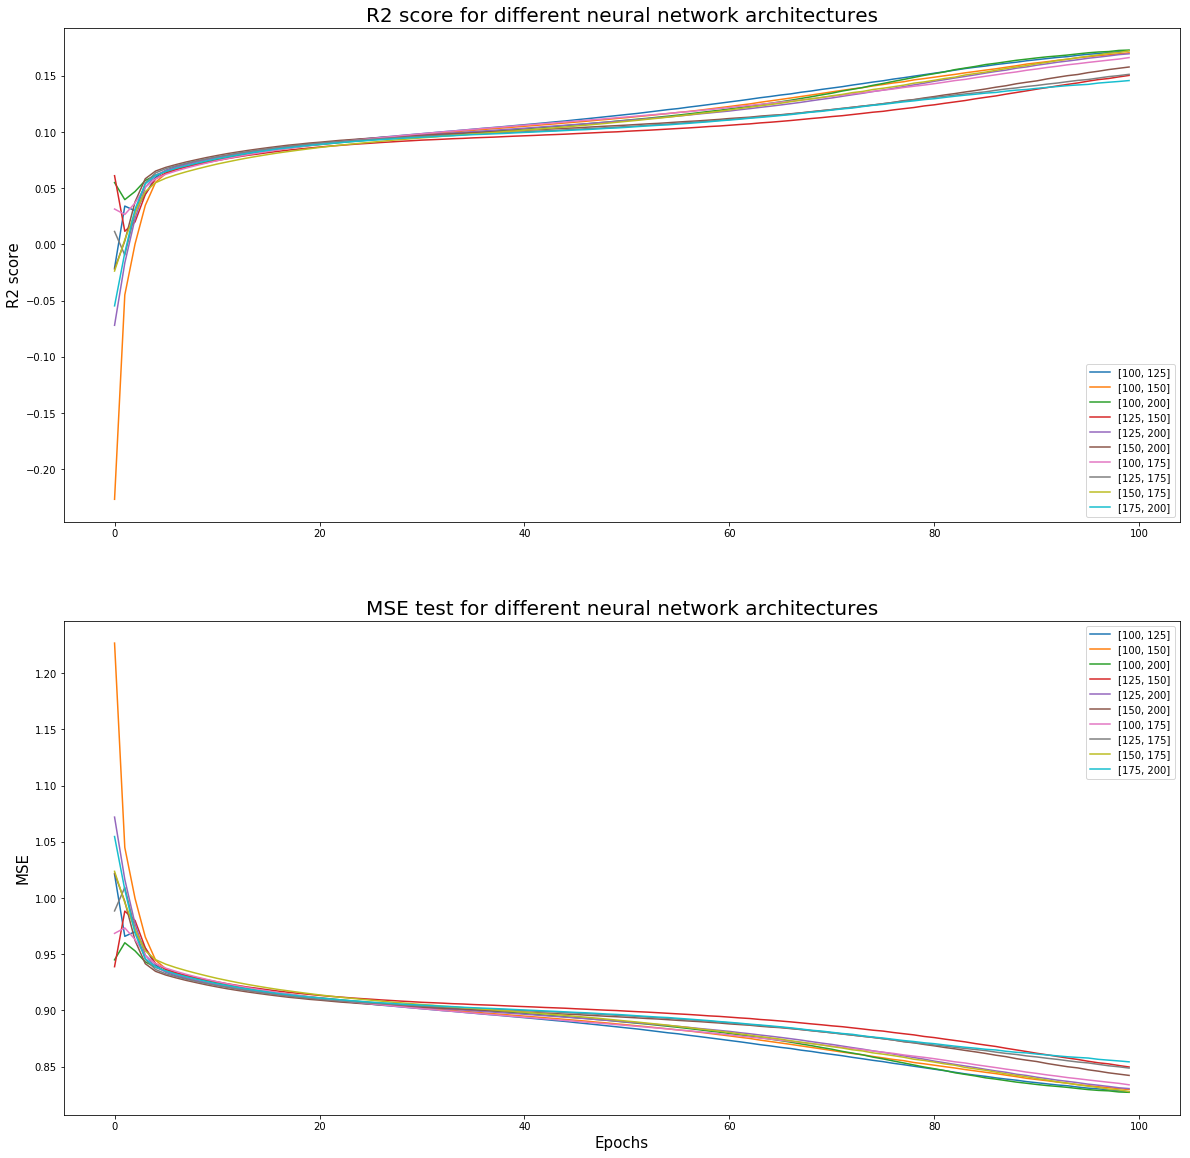

In [17]:
plt.figure(figsize = (20,20))

counter = 0
for model in results:
    mse_test = model.eval_['valid_preform']
    r2_train = model.eval_['valid_preform_r2']

    ax1 = plt.subplot(211)
    plt.plot(r2_train[:200], label = str(combinations_of_nodes[counter])) 
    plt.title("R2 score for different neural network architectures", fontsize = 20)
    plt.ylabel("R2 score", fontsize = 15)
    plt.legend()
    
    # Alle disse blir like.
    ax2 = plt.subplot(212)
    plt.plot(mse_test[:200], label = str(combinations_of_nodes[counter])) 
    plt.title("MSE test for different neural network architectures", fontsize = 20)
    plt.ylabel("MSE", fontsize = 15)
    plt.legend()
    
    counter += 1

plt.xlabel("Epochs", fontsize = 15)
plt.savefig("results/figures/NN_two_hidden_layer_sigmoid_1000epochs_eta0.0001_StandardScaler_mse_r2_1_100epochs_7.png")

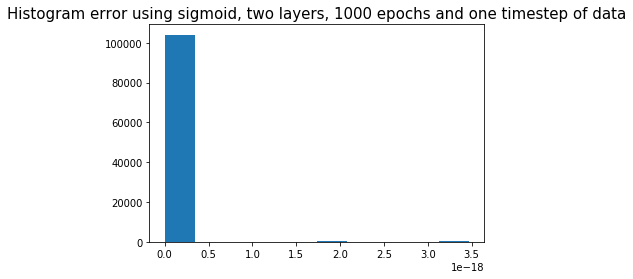

In [18]:
error = results[0].model_error
plt.hist(error)
plt.title("Histogram error using sigmoid, two layers, 1000 epochs and one timestep of data", fontsize = 15)
plt.savefig("results/figures/NN_two_hidden_layer_sigmoid_1000epochs_eta0.0001_featured_scaled_1_error.png")
# They all look the same. 

# Neural network three hidden layers

In [19]:
n_1 = [100, 125, 150]
n_2 = [100, 125, 175]
n_3 = [100, 125, 200]

n_4 = [100, 150, 175]
n_5 = [100, 150, 200]

n_6 = [100, 175, 200]

n_7 = [125, 150, 175]
n_8 = [125, 175, 200]

n_9 = [150, 175, 200]

comb = [n_1, n_2, n_3, n_4, n_5, n_6, n_7, n_8, n_9]


results = []

#permutations_of_nodes = list(itertools.permutations(n_1)) + list(itertools.permutations(n_2)) \
#+ list(itertools.permutations(n_3))+ list(itertools.permutations(n_4)) + list(itertools.permutations(n_5))+ \
#list(itertools.permutations(n_6)) + list(itertools.permutations(n_7)) + list(itertools.permutations(n_8)) +list(itertools.permutations(n_9)) 
    
for per in comb:
    model = NeuralNetRegressor(n_hidden = per,  
                               epochs=100, 
                               eta=0.0001,
                               shuffle=True, 
                               batch_size=10,
                               seed=None, 
                               alpha=0.0001, # Dette er for relu ikke det samme som penaltien i scikit learn  
                               activation='sigmoid')

    p = model.fit(X_train, y_train, X_test, y_test)
    model.predict(X_test)
    results.append(p)
    print("finished model: " + str(per) + " performance " + str(np.nanmean(model.eval_["valid_preform"])) )

finished model: [100, 125, 150] performance 0.9165467302568566
finished model: [100, 125, 175] performance 0.9040233612648659
finished model: [100, 125, 200] performance 0.9068918906852792
finished model: [100, 150, 175] performance 0.911102894138463
finished model: [100, 150, 200] performance 0.9065001261696647
finished model: [100, 175, 200] performance 0.9200440996204386
finished model: [125, 150, 175] performance 0.9054420865272108
finished model: [125, 175, 200] performance 0.9035792991463297
finished model: [150, 175, 200] performance 0.908173248604831


/uio/hume/student-u89/hannasv/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/uio/hume/student-u89/hannasv/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/uio/hume/student-u89/ha

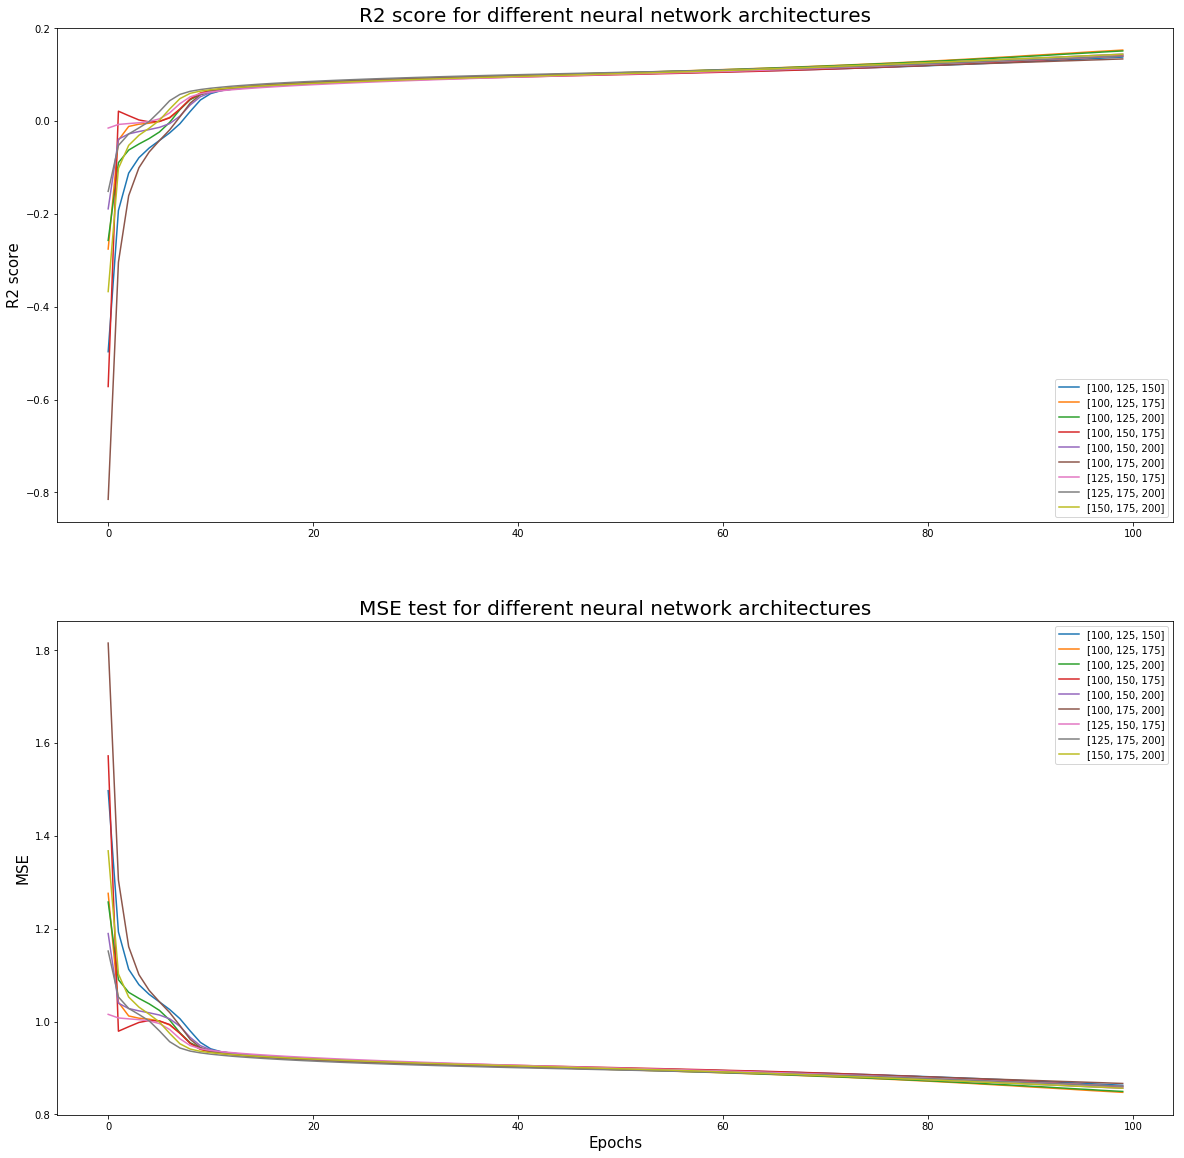

In [20]:
plt.figure(figsize = (20,20))

counter = 0
for model in results:
    mse_test = model.eval_['valid_preform']
    r2_train = model.eval_['valid_preform_r2']

    ax1 = plt.subplot(211)
    plt.plot(r2_train, label = str(comb[counter])) 
    plt.title("R2 score for different neural network architectures", fontsize = 20)
    plt.ylabel("R2 score", fontsize = 15)
    plt.legend()
    
    # Alle disse blir like.
    ax2 = plt.subplot(212)
    plt.plot(mse_test, label = str(comb[counter])) 
    plt.title("MSE test for different neural network architectures", fontsize = 20)
    plt.ylabel("MSE", fontsize = 15)
    plt.legend()
    
    counter += 1

plt.xlabel("Epochs", fontsize = 15)
plt.savefig("results/figures/NN_three_hidden_layer_sigmoid_1000epochs_eta0.0001_StandardScaler_mse_r2_7.png")

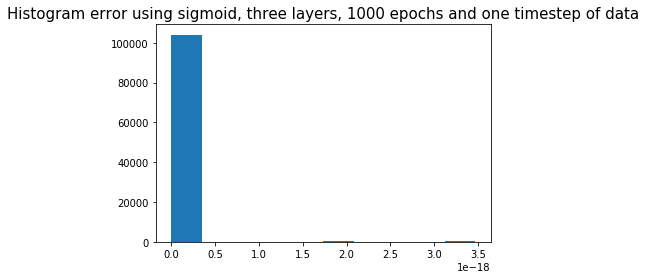

In [21]:
error = results[0].model_error
plt.hist(error)
plt.title("Histogram error using sigmoid, three layers, 1000 epochs and one timestep of data", fontsize = 15)
plt.savefig("results/figures/NN_three_hidden_layer_sigmoid_1000epochs_eta0.0001_featured_scaled_1_error.png")
# They all look the same.

# Net med fire hidden layers

In [22]:
n_1 = [100, 125, 150, 175]
n_2 = [100, 125, 150, 200]
n_3 = [125, 150, 175, 200]

results = []

#permutations_of_nodes = list(itertools.permutations(n_1)) + list(itertools.permutations(n_2)) + list(itertools.permutations(n_3))
comb = [n_1, n_2, n_3]

for per in comb:
    model = NeuralNetRegressor(n_hidden = per,  
                               epochs=100, 
                               eta=0.0001,
                               shuffle=True, 
                               batch_size=10,
                               seed=None, 
                               alpha=0.0001, # Dette er for relu ikke det samme som penaltien i scikit learn  
                               activation='sigmoid')

    p = model.fit(X_train, y_train, X_test, y_test)
    model.predict(X_test)
    results.append(p)
    print("finished model: " + str(per) + " performance " + str(np.nanmean(model.eval_["valid_preform"])) )

finished model: [100, 125, 150, 175] performance 0.9531166774404041
finished model: [100, 125, 150, 200] performance 0.9254067660519248
finished model: [125, 150, 175, 200] performance 0.9274334381062076


/uio/hume/student-u89/hannasv/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/uio/hume/student-u89/hannasv/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/uio/hume/student-u89/ha

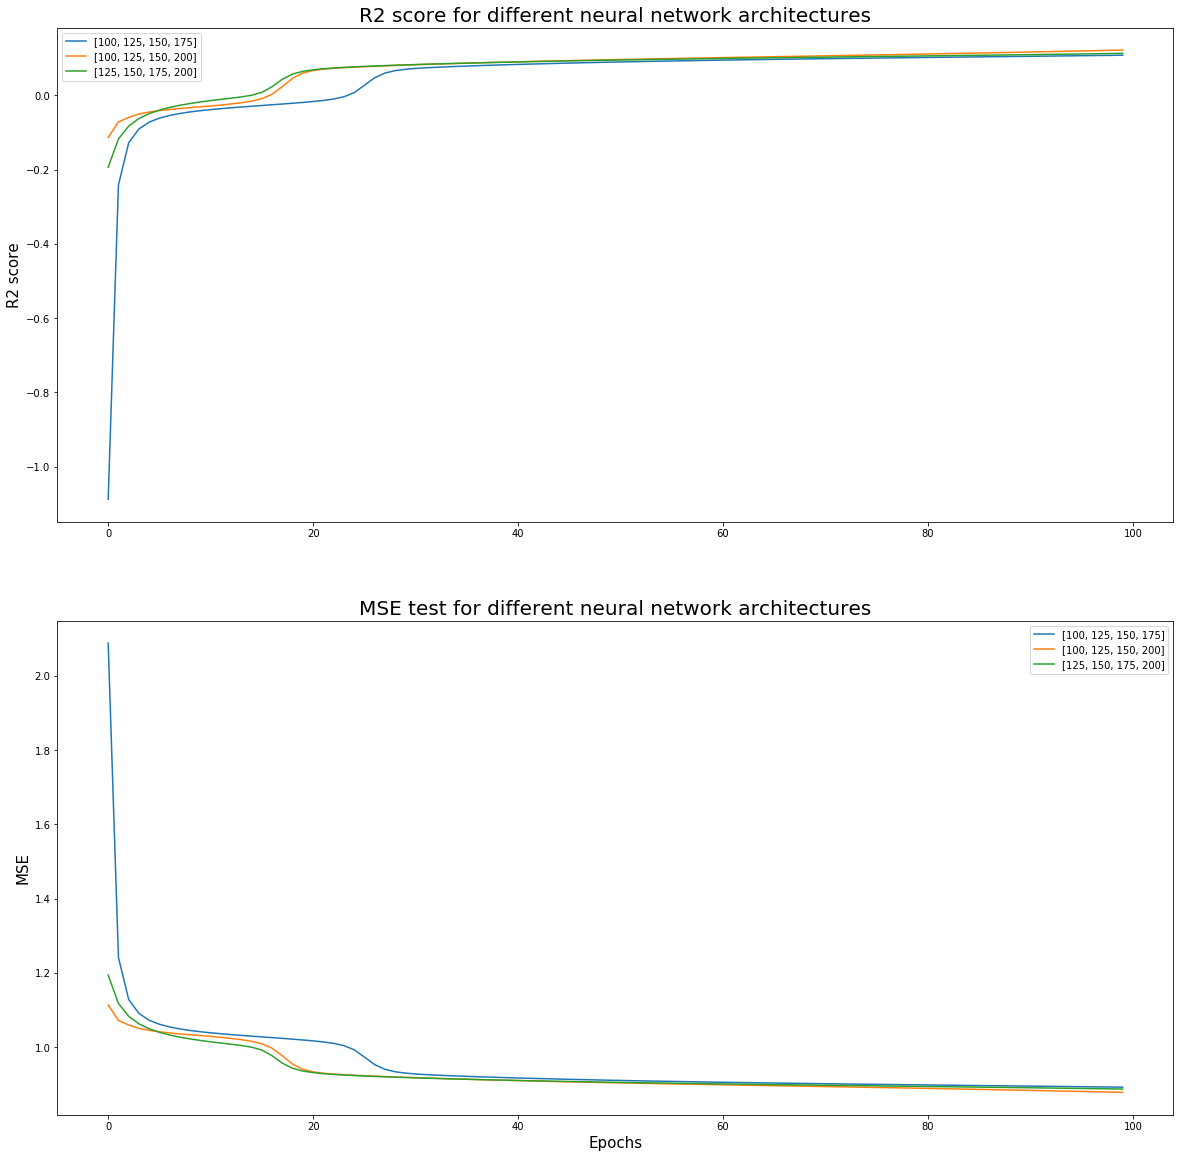

In [23]:
plt.figure(figsize = (20,20))

counter = 0
for model in results:
    mse_test = model.eval_['valid_preform']
    r2_train = model.eval_['valid_preform_r2']

    ax1 = plt.subplot(211)
    plt.plot(r2_train, label = str(comb[counter])) 
    plt.title("R2 score for different neural network architectures", fontsize = 20)
    plt.ylabel("R2 score", fontsize = 15)
    plt.legend()
    
    # Alle disse blir like.
    ax2 = plt.subplot(212)
    plt.plot(mse_test, label = str(comb[counter])) 
    plt.title("MSE test for different neural network architectures", fontsize = 20)
    plt.ylabel("MSE", fontsize = 15)
    plt.legend()
    
    counter += 1

plt.xlabel("Epochs", fontsize = 15)
plt.savefig("results/figures/NN_four_hidden_layer_sigmoid_1000epochs_eta0.0001_StandardScaler_mse_r2_7.png")

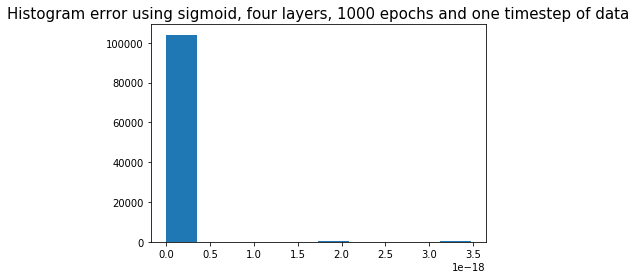

In [24]:
error = results[0].model_error
plt.hist(error)
plt.title("Histogram error using sigmoid, four layers, 1000 epochs and one timestep of data", fontsize = 15)
plt.savefig("results/figures/NN_four_hidden_layer_sigmoid_1000epochs_eta0.0001_featured_scaled_1_error.png")
# They all look the same.

# Same model but slower learning rate.

In [26]:
n_1 = [100, 125, 150, 175]
n_2 = [100, 125, 150, 200]
n_3 = [125, 150, 175, 200]

results = []

#permutations_of_nodes = list(itertools.permutations(n_3)) #+ list(itertools.permutations(n_2)) + list(itertools.permutations(n_3))
comb = [n_1, n_2, n_3]

for per in comb:
    model = NeuralNetRegressor(n_hidden = list(per),  
                               epochs=100, 
                               eta=0.00001,
                               shuffle=True, 
                               batch_size=10,
                               seed=None, 
                               alpha=0.0001, # Dette er for relu ikke det samme som penaltien i scikit learn  
                               activation='sigmoid')

    p = model.fit(X_train, y_train, X_test, y_test)
    model.predict(X_test)
    results.append(p)
    print("finished model: " + str(per) + " performance " + str(np.nanmean(model.eval_["valid_preform"])) )

finished model: [100, 125, 150, 175] performance 1.1167717455658972
finished model: [100, 125, 150, 200] performance 1.2424943524468919
finished model: [125, 150, 175, 200] performance 1.2715134030774449


/uio/hume/student-u89/hannasv/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/uio/hume/student-u89/hannasv/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/uio/hume/student-u89/ha

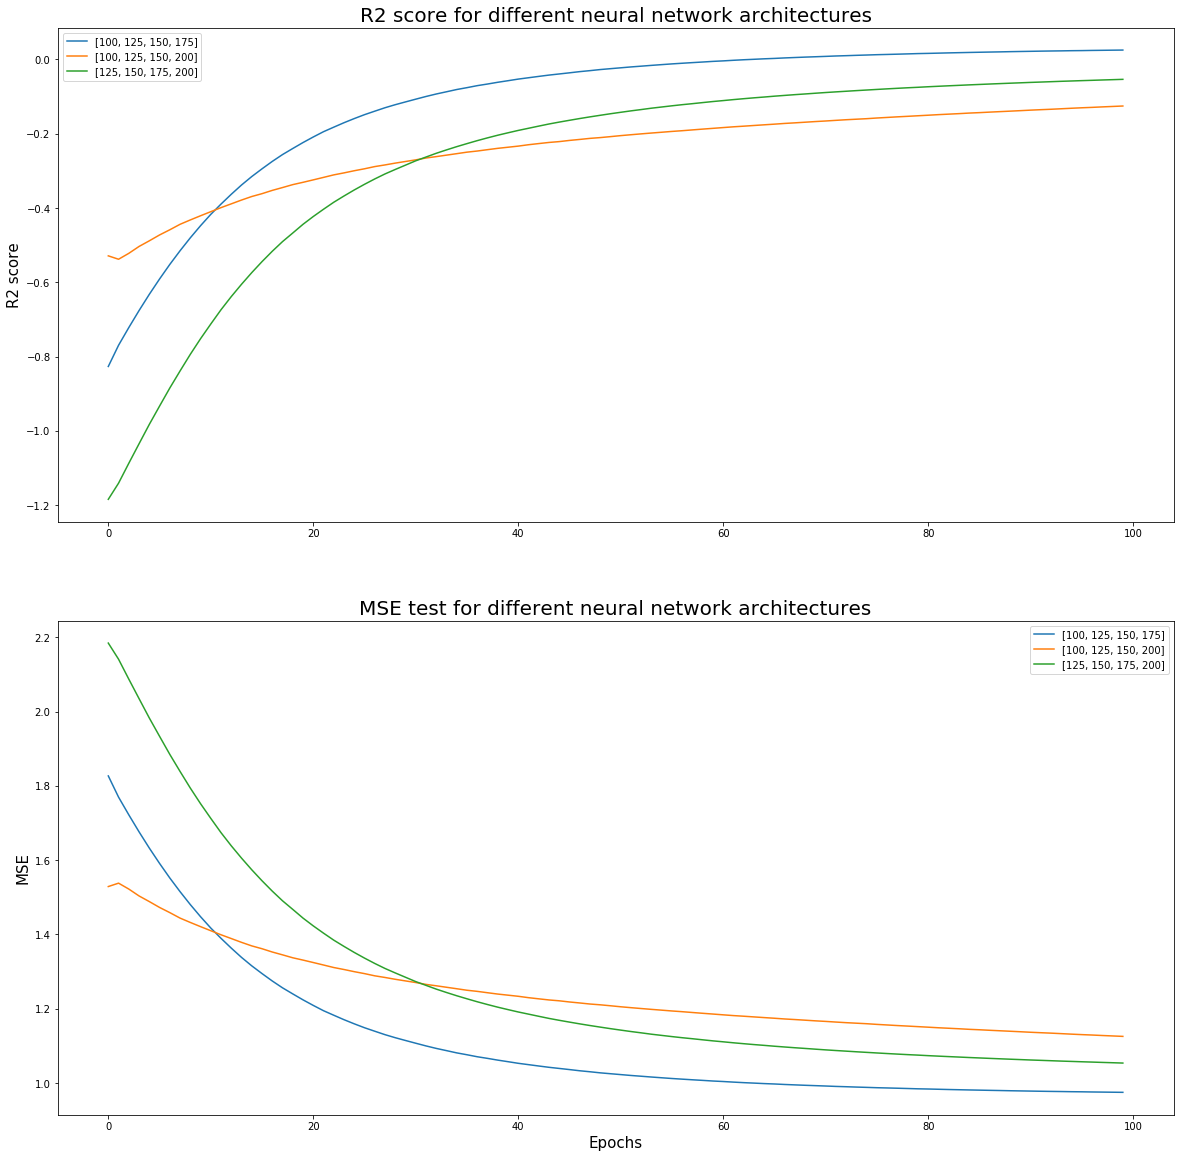

In [27]:
plt.figure(figsize = (20,20))

counter = 0
for model in results:
    mse_test = model.eval_['valid_preform']
    r2_train = model.eval_['valid_preform_r2']

    ax1 = plt.subplot(211)
    plt.plot(r2_train, label = str(comb[counter])) 
    plt.title("R2 score for different neural network architectures", fontsize = 20)
    plt.ylabel("R2 score", fontsize = 15)
    plt.legend()
    
    # Alle disse blir like.
    ax2 = plt.subplot(212)
    plt.plot(mse_test, label = str(comb[counter])) 
    plt.title("MSE test for different neural network architectures", fontsize = 20)
    plt.ylabel("MSE", fontsize = 15)
    plt.legend()
    
    counter += 1

plt.xlabel("Epochs", fontsize = 15)
plt.savefig("results/figures/NN_four_hidden_layer_sigmoid_1000epochs_eta000001_StandardScaler_mse_r2_new_7.png")